## Modelos multivariados
Hata el momento, se ha estudiado modelos univariados. Unicamente se trabajo con una variable endogena que esta explicada por sus rezagos. Esta seccion contara con mas de una endogena que sera explicada por sus propios rezagos, pero tambien por las otras.

Hay dos modelos multivariados conocidos:
* VAR: Vector Autorregresivo
* SVAR: Vector Autorregresivo Estructural

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# !pip install statsmodels --upgrade
import statsmodels.tsa.api as tsa
from econdata import BCRP

import warnings
warnings.simplefilter("ignore")

Obtención de las series que serán usadas en en los modelos:
* Índice de precios de exportación (IPX) - var. % anual
* Producto Bruto Interno (PBI) - var. % anual
* Inflación - %
* Tasa de interés interbancaria (R) - %

In [329]:
# Data mensual
dta_mens = BCRP.get_data(
    {
        #'PN01701BM': 'IPX',
        'PN38705PM': 'IPC',
        'PN07819NM': 'R'
    },
    fechaini='1999-01-01',
    fechafin='2019-12-01'
)

dta_mens.index = pd.to_datetime(dta_mens.index)
dta_mens = dta_mens.resample('Q').mean()
dta_mens.index = pd.period_range('1999Q1', '2019Q4', freq='Q')

# Data trimestral
dta_trim = BCRP.get_data(
    {
        'PN02538AQ': 'PBI'
    },
    fechaini='1998Q1',
    fechafin='2019Q4'
)

# Unión
df = pd.concat(
    [
        dta_mens,
        dta_trim
    ],
    axis=1
)

# Variaciones
variables = ['IPC', 'PBI'] # 'IPX', 
df[variables] = df[variables]/df[variables].shift(4) * 100 - 100
df.rename({'IPC': 'Inflación'}, axis=1, inplace=True)

# Final
df.dropna(inplace=True)
series = ['PBI', 'Inflación', 'R'] # 'IPX', 
df = df[series]
df.head()

,PBI,Inflación,R
2000Q1,6.756250,3.873379,12.170000
2000Q2,4.931338,3.447473,14.383333
2000Q3,2.680012,3.710886,11.010000
2000Q4,-3.177518,4.001129,13.316667
2001Q1,-5.330526,3.683259,10.694186


### VAR
Un modelo VAR es util para realizar proyecciones. Esta metodologia ya tiene a las variables en su forma reducida, por lo que directamente puede ser estimada por MCO siguiendo el proceso:
$$Y_t = A + B_1 Y_{t-1} + B_2 Y_{t-2} + ... + B_p Y_{t-p} + U_t$$

donde $B_i$ es una matriz $K\cdot K$ para todo $i$.

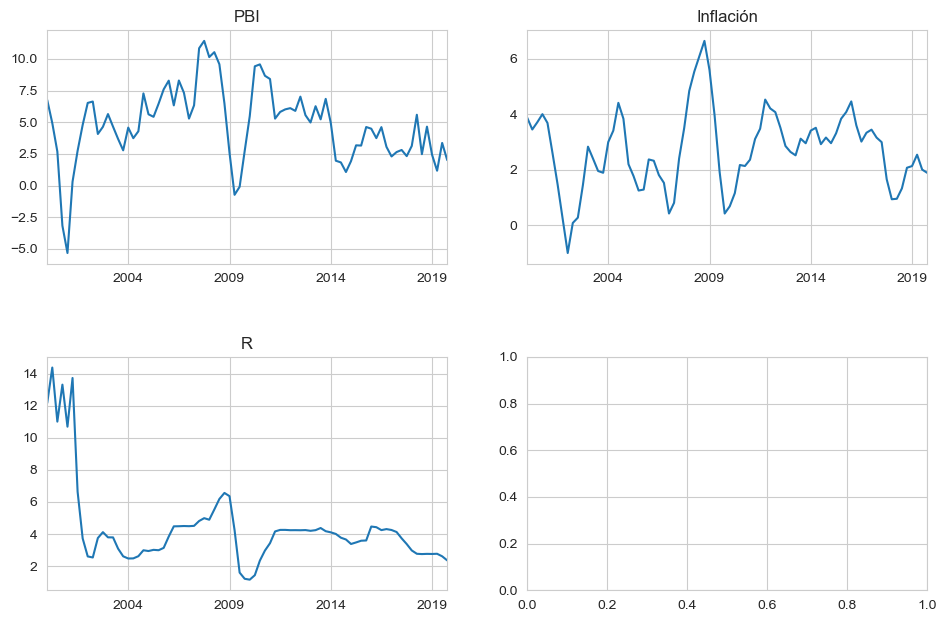

In [330]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

for i in enumerate(df.columns):
    ax = plt.subplot(2, 2, i[0]+1)
    df[i[1]].plot()
    plt.title(df.columns[i[0]])
    plt.legend().remove()
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)
plt.show()

Para crear un modelo, es necesario primero saber cual es mejor modelo:

In [331]:
model_var = tsa.VAR(df)
order = model_var.select_order(maxlags=4)

order.summary()

,AIC,BIC,FPE,HQIC
0,3.814,3.906,45.31,3.850
1,0.2012,0.5692,1.223,0.3483
2,-0.1711*,0.4729*,0.8440*,0.08626*
3,-0.07482,0.8452,0.9322,0.2929
4,-0.1129,1.083,0.9024,0.3651


Queda seleccionado, por todos los criterios de informacion, que la maxima cantidad de lags es 2

In [333]:
results = tsa.VAR(df).fit(maxlags=2)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Apr, 2023
Time:                     20:25:34
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.751967
Nobs:                     78.0000    HQIC:                  0.371469
Log likelihood:          -315.613    FPE:                    1.12628
AIC:                     0.117468    Det(Omega_mle):        0.870309
--------------------------------------------------------------------
Results for equation PBI
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                2.822304         0.703975            4.009           0.000
L1.PBI               0.919189         0.116919            7.862           0.000
L1.Inflación        -0.165708         0.302950           -0.547   

Al graficar las ACFs de los residuos, encontramos que no existe autocorrelacion serial

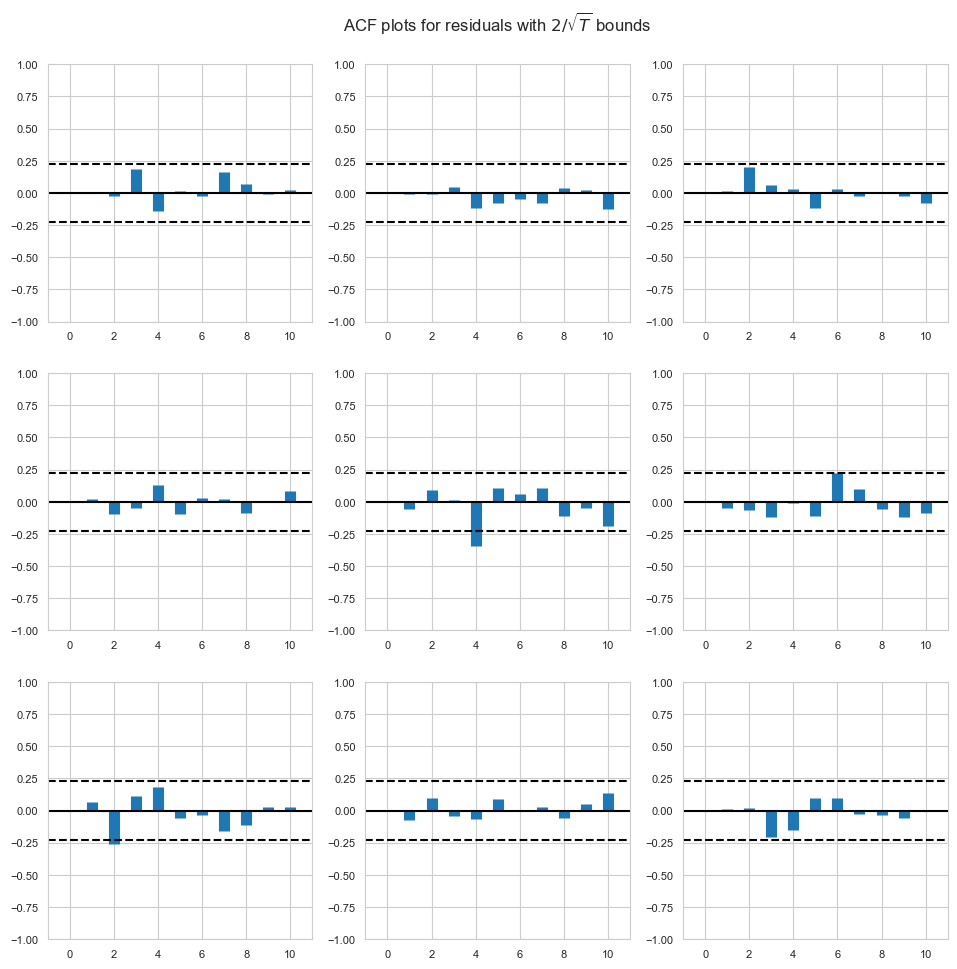

In [334]:
results.plot_acorr()

plt.show()

#### IRFs: Impulse Response Functions
Las funciones se estiman de la forma del $MA(\infty)$
$$Y_t = \mu + \sum_{i=0}^{\infty} \Theta_i \epsilon_{t-i}$$

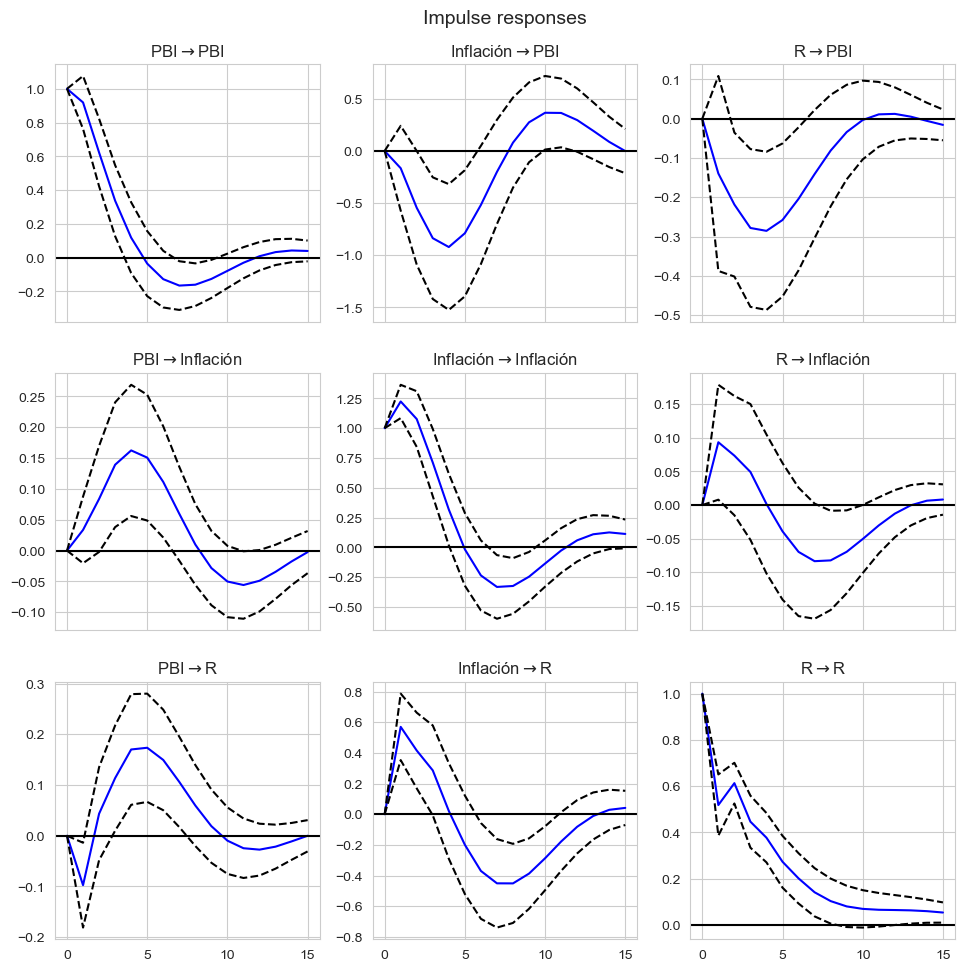

In [335]:
irfs = results.irf(15)

irfs.plot(orth=False, signif=0.18)
plt.show()

Tambien se puede pedir las IRFs de solo un choque

In [336]:
irfs.plot(impulse='IPX', figsize=(4, 8))

plt.show()

ValueError: 'IPX' is not in list

Las IRFs acumuladas pueden ser graficadas de la siguiente manera:

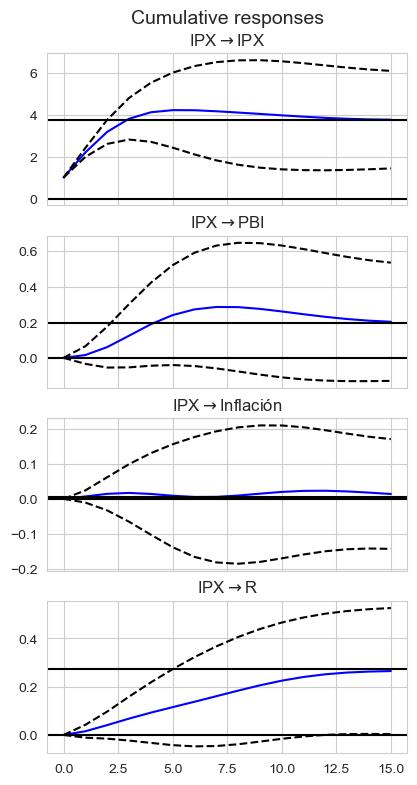

In [89]:
irfs.plot_cum_effects(orth=False, impulse='IPX', figsize=(4, 8))

plt.show()

#### FEVD: Forecast Error Variance Decomposition
La descomposicion de la varianza nos muestra como se descompone el error de proyeccion de cada variable con respecto a los choques indivuales de todas las variables. De esta manera podemos darnos una idea de la relevancia de cada una de las variables en la proyeccion de un unica variable

\begin{align}\begin{aligned}\omega_{jk, i} = \sum_{i=0}^{h-1} (e_j^\prime \Theta_i e_k)^2 / \mathrm{MSE}_j(h)\\\mathrm{MSE}_j(h) = \sum_{i=0}^{h-1} e_j^\prime \Phi_i \Sigma_u \Phi_i^\prime e_j\end{aligned}\end{align}

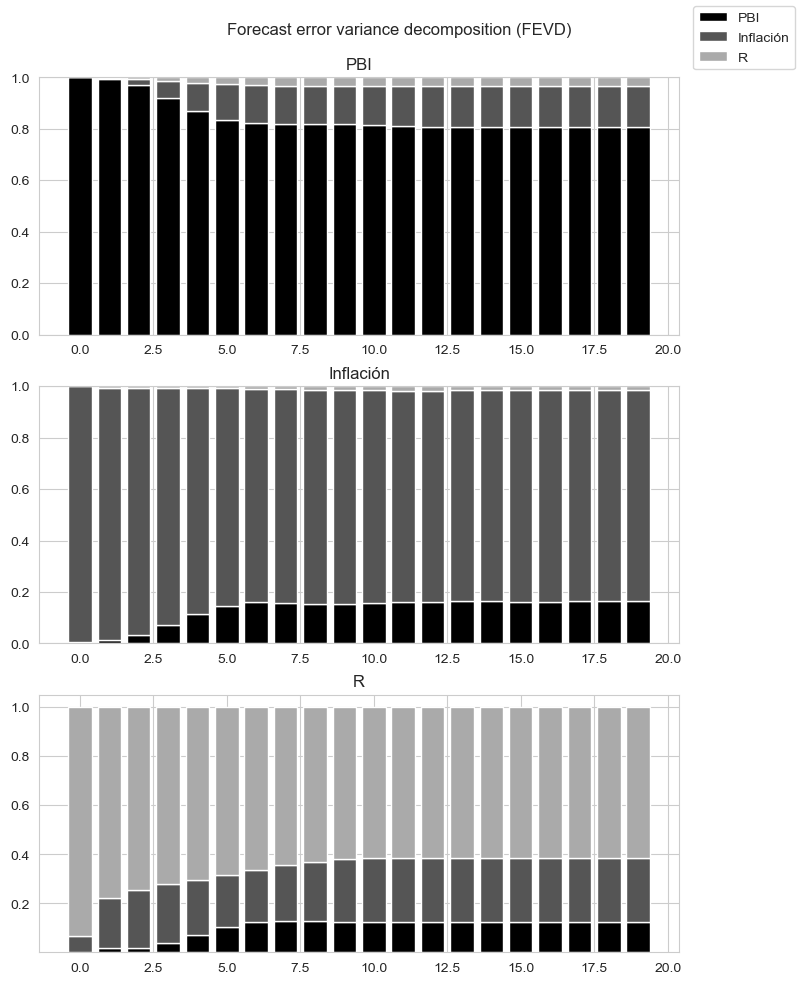

In [337]:
fevd = results.fevd(20)

colors = ['blue', 'green', 'red', 'purple']
fig = fevd.plot(figsize=(8, 10))

plt.show()

#### Forecast
Finalmente, se realizara las proyecciones del modelo. Estas seran _out-sample_

In [339]:
order = results.k_ar

forecast_var = results.forecast(df.values[-order:], steps=5)
forecast_var

array([[3.02374292, 1.86563942, 2.62315606],
       [4.24999314, 1.95331386, 2.4316572 ],
       [5.15618866, 2.09009906, 2.51565039],
       [5.66320715, 2.29652981, 2.64513454],
       [5.85294373, 2.52597445, 2.87146844]])

Aunque esto solo nos da el valor de la mediana. Si deseamos tambien los valores de los intervalos de confianza, se debe correr lo siguiente:

In [340]:
order = results.k_ar

forecast_var = results.forecast_interval(df.values[-order:], steps=5, alpha=0.05)
forecast_var

(array([[3.02374292, 1.86563942, 2.62315606],
        [4.24999314, 1.95331386, 2.4316572 ],
        [5.15618866, 2.09009906, 2.51565039],
        [5.66320715, 2.29652981, 2.64513454],
        [5.85294373, 2.52597445, 2.87146844]]),
 array([[-0.38487654,  0.69158506,  0.80459826],
        [-0.38469254,  0.04751231,  0.18603658],
        [ 0.00800331, -0.24689202, -0.09793772],
        [ 0.26403406, -0.24929717, -0.16706142],
        [ 0.28678774, -0.11087994, -0.08273248]]),
 array([[ 6.43236238,  3.03969378,  4.44171386],
        [ 8.88467882,  3.85911541,  4.67727782],
        [10.304374  ,  4.42709013,  5.1292385 ],
        [11.06238024,  4.8423568 ,  5.45733049],
        [11.41909972,  5.16282884,  5.82566936]]))

Donde los resultados tienen el siguiente orden: 
* Mediana
* Valor minimo
* Valor maximo

Graficamente se vera asi:

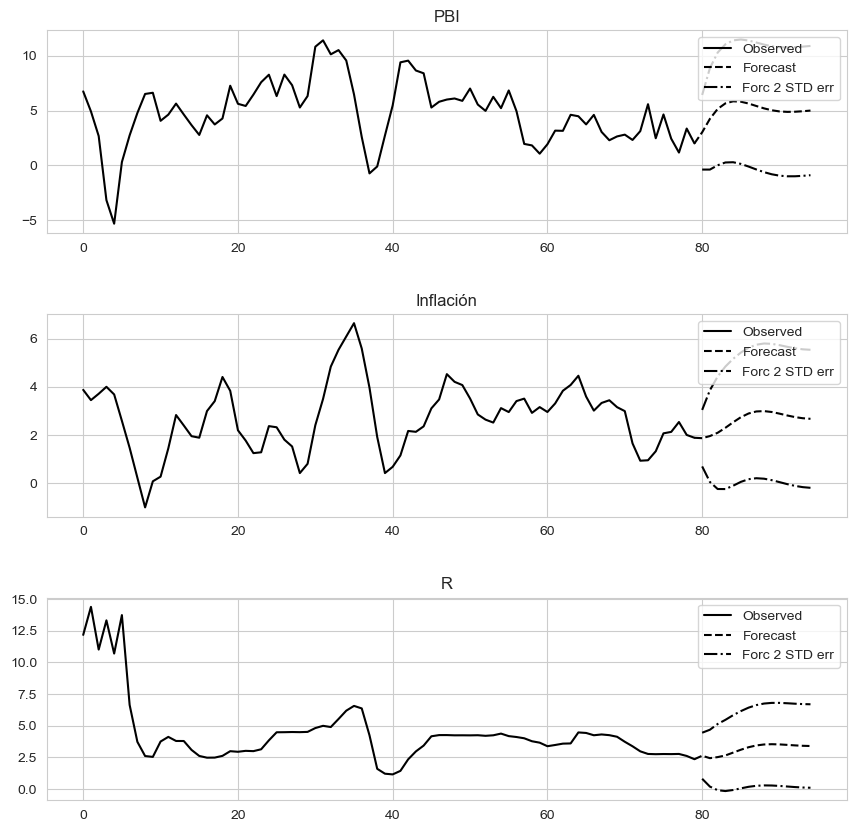

In [342]:
results.plot_forecast(15, alpha=0.05)

plt.subplots_adjust(left=0.2, right=1, hspace=0.4, wspace=0.2)
plt.show()

#### Historical Decomposition (HD)

In [ ]:
def HistDec(e, C, A, mu, Zp, n, p, T):
    """
    Historical Decomposition function for Nonlinear Vector Autoregression Models.

    Arguments:
    e -- structural errors: (n x T) numpy array
    C -- inverse contemporaneous matrix: (n x n x T) numpy array
    A -- reduced form coefficients: (np x np x T) numpy array
    mu -- intercepts: (n x T) numpy array
    Zp -- numpy array
    n -- number of dependent variables
    p -- lags
    T -- estimation sample

    Returns:
    HD_shocks -- each variable in each row; each shock contribution in each column
    HD_initial -- numpy array
    HD_steady -- numpy array
    """

    HD_shocks = np.zeros((n*p, n, T))
    HD_shocks[:, :, 0] = (np.matmul(H, np.squeeze(C[:, :, 0])) * e[:, 0]).T
    for i in range(1, T):
        HD_shocks[:, :, i] = ((np.matmul(H, np.squeeze(C[:, :, i])) * e[:, i]).T 
                              + np.matmul(np.squeeze(A[:, :, i]), HD_shocks[:, :, i-1]))

    HD_initial = np.zeros((n*p, T))
    HD_initial[:, 0] = np.matmul(np.squeeze(A[:, :, T-1]), Zp)
    for ii in range(1, T):
        HD_initial[:, ii] = np.matmul(np.squeeze(A[:, :, T-1]), HD_initial[:, ii-1])

    HD_steady = np.zeros((n*p, T))
    HD_steady[:, 0] = np.matmul(H, mu[:, 0])
    for iii in range(1, T):
        HD_steady[:, iii] = (np.matmul(H, mu[:, iii])
                             + np.matmul(np.squeeze(A[:, :, T-1]), HD_steady[:, iii-1]))

    return HD_shocks, HD_initial, HD_steady

### SVAR
Un modelo SVAR es util para realizar analisis de politica. Esta metodologia no se encuentra en su forma reducida, sino en su forma estructural. Por lo tanto, es necesario realizar una identificacion al siguiente modelo:
$$AY_t = A_1 Y_{t-1} + A_2 Y_{t-2} + ... + A_p Y_{t-p} + E_t$$

donde $B_i$ es una matriz $K\cdot K$ para todo $i$. La matriz $A$ representa la matriz de efectos contemporaneos. Al estimar se debe tomar en consideracion que se realizara en su forma reducida:
$$Y_t = B_1 Y_{t-1} + B_2 Y_{t-2} + ... + B_p Y_{t-p} + U_t$$

Por lo general, la identificacion se hace mediante Cholesky.

Por el momento, por falta de literatura que me permita entender bien como trabajan las funciones de SVAR en `statsmodels`, dejo mi avance hasta este punto. Queda hacia futuro:
* Estimar el modelo SVAR y descomponer los parametros.
* Estimar IRFs, FEVD, HD para el SVAR.
* Proyectar.

#### Referencias:
* https://www.statsmodels.org/stable/vector_ar.html#var
* https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/